<a href="https://colab.research.google.com/github/joestrada1022/ASL_CNN_Model/blob/main/ASL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Goal:
Our project goal is to use a **CNN** (Convolutional Neural Network) to predict the translations of **American Sign Language**.


### Initialization (Run First)

In [ ]:
!pip install mediapipe
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, gdown
from google.colab.patches import cv2_imshow #Makes the opencv image display compatible with Jupyter Notebook
from pathlib import Path




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import mediapipe as mp
from PIL import Image as PILImage

## Section 1: Dataset Discovery and Processing

In [ ]:
#Loading the combined dataset
input_filename = "sign_mnist.csv"

# Replace 'file_id' with the ID of your file
file_id = '1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS
From (redirected): https://drive.google.com/uc?id=1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS&confirm=t&uuid=267930c7-7e56-4c0a-a48f-8547723de07f
To: /content/sign_mnist.csv
100%|██████████| 105M/105M [00:02<00:00, 46.2MB/s] 


### **Data Discovery**

In [ ]:
dataset = pd.read_csv('sign_mnist.csv')

print("First 5 values in the dataset:\n" , dataset.head())
print("\nLast 5 values in the dataset:\n" ,dataset.tail())
print("\nSummary of the data:")
print(dataset.info())
print("\nStatistical summary of the data:\n" ,dataset.describe())
print("\n Shape of the dataset:", dataset.shape)

First 5 values in the dataset:
    label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784 

### **Handling Missing values in the dataset**

In [ ]:
#NaN values in the dataset ?
nan = dataset.isnull().sum()
print(nan[nan != 0])

Series([], dtype: int64)


### **Analysing the dataset**

In [ ]:
#Analyse the pixels intensity values
subset_pixels = dataset.iloc[:, 1:] #Removes labels
subset_pixels.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,...,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.00000
mean,145.857077,148.903226,151.677824,153.984983,156.616600,158.904121,160.847171,162.610911,164.293384,165.901868,...,140.574985,147.090479,152.791261,158.403211,161.332140,162.097063,161.923528,161.077136,160.211309,158.77919
std,41.839313,40.355637,39.355866,38.762706,37.252215,36.130753,35.274594,34.137995,32.882325,31.514255,...,63.914830,65.438124,64.713282,64.112086,64.055046,63.886450,64.166570,63.892399,64.395504,65.25230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,122.000000,126.000000,130.000000,133.000000,137.000000,140.000000,143.000000,145.000000,146.000000,148.000000,...,91.500000,96.000000,102.000000,110.000000,118.000000,122.000000,124.000000,124.000000,124.000000,121.00000
50%,151.000000,154.000000,156.000000,158.000000,160.000000,163.000000,164.000000,166.000000,167.000000,168.000000,...,142.000000,161.000000,172.000000,179.000000,183.000000,183.000000,183.000000,182.000000,182.000000,181.00000
75%,175.000000,177.000000,179.000000,180.000000,181.000000,182.000000,184.000000,185.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,205.000000,204.00000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000


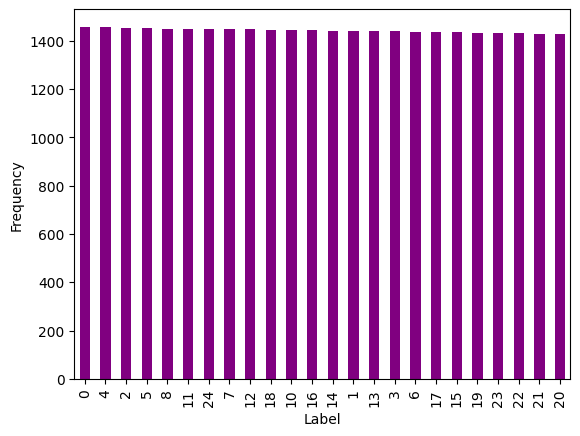

In [ ]:
#Distribution of the digits in the dataset
_ = dataset['label'].value_counts().plot(kind = 'bar', color = 'purple')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [ ]:
def display_digits(start_index, end_index, dataset):
    """
    Displays handwritten digit images from the dataset
    within the specified range [start_index, end_index].
    """

    images = np.arange(start_index, end_index)  # Setting the range

    subset_images = dataset.iloc[images, :]  # Selects images within that range
    subset_images.index = range(1, end_index - start_index + 1)  # Resets index of subset images to start at 1
    labels = subset_images['label'].values  # Get labels of the selected images
    subset_images.drop(columns=['label'], inplace=True)  # Dropping column from the dataframe

    num_images = end_index - start_index
    rows = (num_images // 8) + 1

    # Converts pixel data to image data
    for i, row in subset_images.iterrows():
        plt.subplot(rows, 8, i)
        pixels = row.values.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{labels[i-1]}")  # Display label next to each image

    plt.show()


<ipython-input-9-8d6c981fcf1e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_images.drop(columns=['label'], inplace=True)  # Dropping column from the dataframe


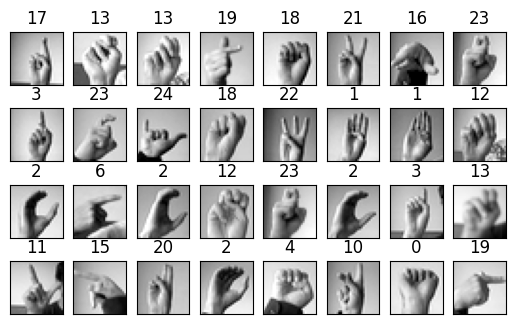

In [ ]:
display_digits(16, 48, dataset)

### **Splitting the dataset into training, validating and testing datasets proportionally**

In [ ]:
#Initializing target Value/label array and poupulating it with 0 through 25(exclusive) to represent our labels
target_values =  list(range(0, 25))

# Initialize empty dictionaries to store the splits
train_splits = {target: None for target in target_values}
valid_splits = {target: None for target in target_values}
test_splits = {target: None for target in target_values}

# Split the data for each target value
for target in target_values:
    target_data = dataset[dataset['label'] == target]
    train_splits[target] = target_data.sample(frac=0.7)
    valid_splits[target] = target_data.sample(frac=0.1)
    test_splits[target] = target_data.sample(frac=0.2)

# Extract the resulting data splits for each target value
train = pd.concat([train_splits[target] for target in target_values])
val = pd.concat([valid_splits[target] for target in target_values])
test = pd.concat([test_splits[target] for target in target_values])

# #Converting the files to a csv type
# train.to_csv("trainingDataASL.csv", index=False, float_format="%.5f")
# val.to_csv("validatingDataASL.csv", index=False, float_format="%.5f")
# test.to_csv("testingDataASL.csv", index=False, float_format="%.5f")

Split data files stored under content folder


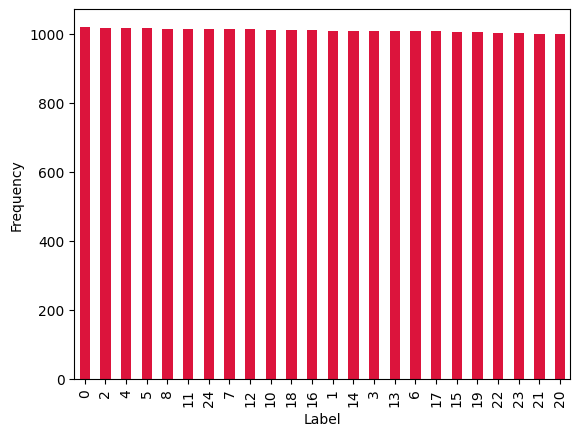

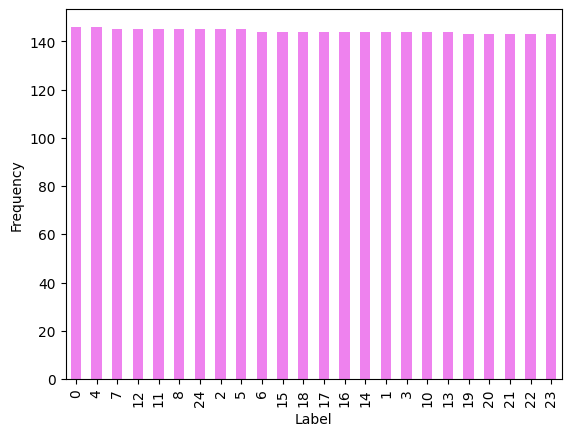

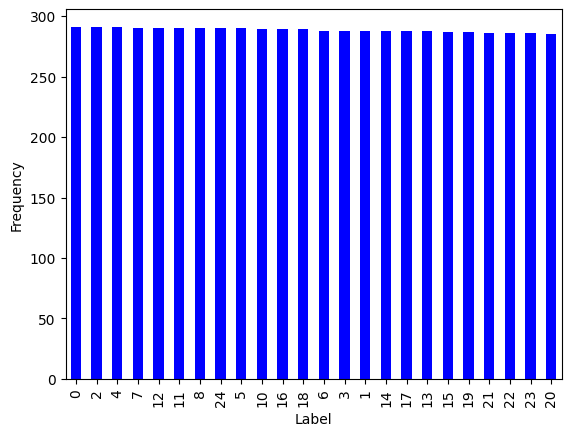

In [ ]:
#Distribution of the digits in the training dataset
_ = train['label'].value_counts().plot(kind = 'bar', color = 'crimson')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

#Distribution of the digits in the validating dataset
_ = val['label'].value_counts().plot(kind = 'bar', color = 'violet')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

#Distribution of the digits in the testing dataset
_ = test['label'].value_counts().plot(kind = 'bar', color = 'blue')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

## **Scaling/Reshaping the dataset for CNN**


In [ ]:
#Loading the training and validating datasets

trainFile = "trainingDataASL.csv"
trainID = '1ktLoOffkeEN4H92KsTLpMV_tnh1rMXOg'
if not os.path.isfile(trainFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + trainID, trainFile, quiet=False)

# validateFile = "validatingDataASL.csv"
# validateID = '1lA-Qz3d0PMkPDaqoetzqOO_DLX8nCdXk'
# if not os.path.isfile(validateFile):
#   # Downloading the file
#   gdown.download('https://drive.google.com/uc?id=' + validateID, validateFile, quiet=False)

testFile = "testingDataASL.csv"
testID = '1Dbh5eXSRVr8OVDohQbybqyuriIqLjIQ1'
if not os.path.isfile(testFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + testID, testFile, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ktLoOffkeEN4H92KsTLpMV_tnh1rMXOg
To: /content/trainingDataASL.csv
100%|██████████| 83.3M/83.3M [00:01<00:00, 54.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dbh5eXSRVr8OVDohQbybqyuriIqLjIQ1
To: /content/testingDataASL.csv
100%|██████████| 21.8M/21.8M [00:00<00:00, 37.3MB/s]


In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
def prepare_dataset(data: pd.DataFrame):

  data_label = data['label']
  data_values = data.drop(['label'], axis=1)

  # Reshape dataset to fit into CNN
  X_data = data_values.values
  X_data = data_values.values.reshape(-1, 28, 28, 1)

  # Normalize pixel intensity to 0-1
  X_data = X_data / 255.0

  # One-hot encode labels
  Y_data = lb.fit_transform(data_label)

  return X_data, Y_data



In [ ]:
trainData = pd.read_csv('trainingDataASL.csv')
xTrain, yTrain = prepare_dataset(trainData)
print(xTrain.shape, yTrain.shape)

testData = pd.read_csv('testingDataASL.csv')
xTest, yTest = prepare_dataset(testData)
print(xTest.shape, yTest.shape)

# valData = pd.read_csv('validatingDataASL.csv')
# xVal, yVal = prepare_dataset(valData)
# print(xVal.shape, yVal.shape)

(27455, 28, 28, 1) (27455, 24)
(7172, 28, 28, 1) (7172, 24)


## TensorFlow CNN Model


In [ ]:
model = Sequential()

# Add convolution layers, relu, and maxpooling
model.add(Conv2D(128, kernel_size=(5,5), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2))

model.add(Conv2D(64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(32, kernel_size=(2,2), strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

# Flatten output for fully connected layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.15))

# Output layer
model.add(Dense(units=24, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 32)          0

In [ ]:
# compile model
'''
- Using adam optimizer because adam adjusts the learning rate during training
- Using crossentropy because...
'''
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# data batch
train_generator = ImageDataGenerator(rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=False,
                                  fill_mode='nearest')

In [ ]:
model.fit(train_generator.flow(xTrain, yTrain, batch_size=128),
          epochs=100, validation_data=(xTest, yTest),
          shuffle=1
          )

Epoch 1/100
215/215 [==============================] - 10s 48ms/step - loss: 1.0578 - accuracy: 0.6394 - val_loss: 0.6048 - val_accuracy: 0.7977
Epoch 2/100
215/215 [==============================] - 10s 48ms/step - loss: 0.9374 - accuracy: 0.6801 - val_loss: 0.5121 - val_accuracy: 0.8087
Epoch 3/100
215/215 [==============================] - 10s 48ms/step - loss: 0.8469 - accuracy: 0.7091 - val_loss: 0.4167 - val_accuracy: 0.8521
Epoch 4/100
215/215 [==============================] - 10s 48ms/step - loss: 0.7652 - accuracy: 0.7330 - val_loss: 0.3641 - val_accuracy: 0.8670
Epoch 5/100
215/215 [==============================] - 10s 48ms/step - loss: 0.7180 - accuracy: 0.7545 - val_loss: 0.3308 - val_accuracy: 0.8875
Epoch 6/100
215/215 [==============================] - 10s 48ms/step - loss: 0.6560 - accuracy: 0.7733 - val_loss: 0.4967 - val_accuracy: 0.8143
Epoch 7/100
215/215 [==============================] - 10s 48ms/step - loss: 0.5898 - accuracy: 0.7959 - val_loss: 0.3500 - val_ac

In [ ]:
# save for future use
model.save("new_best.keras")

In [ ]:
#Loading the combined dataset
input_filename = "new_best.keras"
# Replace 'file_id' with the ID of your file
file_id = '1i2ulpiYHXJ8Hp5jA9JSG-DvFvyrKmRQ9'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1i2ulpiYHXJ8Hp5jA9JSG-DvFvyrKmRQ9
To: /content/new_best.keras
100%|██████████| 1.42M/1.42M [00:00<00:00, 23.6MB/s]


In [ ]:
model = load_model('new_best.keras')

In [ ]:
(testing_loss, testing_accuracy)=model.evaluate(xTest,yTest,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

57/57 [==============================] - 1s 12ms/step - loss: 0.0077 - accuracy: 0.9983
Testing Loss: 0.0077, Testing Accuracy: 0.9983
MODEL ACCURACY = 99.832683801651%


In [ ]:
def skin_detection(image1):
    # Convert image to YUV color space
    yuv_image = cv2.cvtColor(image1, cv2.COLOR_BGR2YUV)

    # Extract Y, U, and V channels
    Y, U, V = cv2.split(yuv_image)

    # Define thresholds for skin detection
    y_threshold = cv2.inRange(Y, 35, 125)

    # theta_threshold = cv2.inRange(np.arctan(V/U), 105, 150)
    theta_threshold = cv2.inRange(U, 105, 135)

    # Combine the thresholds
    skin_mask = cv2.bitwise_and(y_threshold, theta_threshold)
    skin_mask = cv2.threshold(skin_mask, 0, 255, cv2.THRESH_OTSU)[1]



    return skin_mask

def predict_gesture(frame, coords, model, lb, clustering=False):
    letter_labels = {
        0: 'A',
        1: 'B',
        2: 'C',
        3: 'D',
        4: 'E',
        5: 'F',
        6: 'G',
        7: 'H',
        8: 'I',
        10: 'K',
        11: 'L',
        12: 'M',
        13: 'N',
        14: 'O',
        15: 'P',
        16: 'Q',
        17: 'R',
        18: 'S',
        19: 'T',
        20: 'U',
        21: 'V',
        22: 'W',
        23: 'X',
        24: 'Y',
    }


    # grayscale
    if clustering:
      gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
      gray = skin_detection(frame)
    # crop to bounding box
    x1, y1, x2, y2 = coords
    w = x2 - x1
    h = y2 - y1
    gray = gray[y1:y1 + h, x1:x1 + w]
    # cv2_imshow(gray)

    # reshape
    gray = cv2.resize(gray, (28,28))

    # Create batch
    img_array = np.expand_dims(gray, axis=0)

    img_array = img_array.astype(np.float32) / 255.0


    # Predict the gesture
    predictions = model.predict(img_array, verbose=0)
    class_idx = np.argmax(predictions[0])

    conf = np.amax(predictions)
    predicted_label = lb.classes_[class_idx]
    return letter_labels[predicted_label], conf

#Loading datasets for ANN Model

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [ ]:
#Loading the training and validating datasets

trainFile = "/content/trainingDataASL.csv"
trainID = '1tmakkWkKILZp6RhI13aY2wCY8Urs1OTq'
if not os.path.isfile(trainFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + trainID, trainFile, quiet=False)

validateFile = "/content/validatingDataASL.csv"
validateID = '1lA-Qz3d0PMkPDaqoetzqOO_DLX8nCdXk'
if not os.path.isfile(validateFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + validateID, validateFile, quiet=False)

testFile = "/content/testingDataASL.csv"
testID = '1anuMBsprWOrrBJ51NI4WziEh_Ve4EQm1'
if not os.path.isfile(testFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + testID, testFile, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tmakkWkKILZp6RhI13aY2wCY8Urs1OTq
To: /content/trainingDataASL.csv
100%|██████████| 73.5M/73.5M [00:01<00:00, 48.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lA-Qz3d0PMkPDaqoetzqOO_DLX8nCdXk
To: /content/validatingDataASL.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1anuMBsprWOrrBJ51NI4WziEh_Ve4EQm1
To: /content/testingDataASL.csv
100%|██████████| 21.0M/21.0M [00:00<00:00, 122MB/s] 


In [ ]:

def prepareANNdataset(data: pd.DataFrame):

  # Extract labels and data values
  data_label = data['label']
  data_values = data.drop(['label'], axis=1)

  # Reshape data to fit into CNN
  X_data = data_values.values
  X_data = data_values.values.reshape(-1, 784, 1)

  # Normalize pixel intensity to 0-1
  X_data = X_data / 255.0

  # Reshape labels
  y_data = data_label.values
  #y_data = data_values.values.reshape(-1, 24)
  if y_data.ndim == 1:
    y_data = y_data.reshape(-1, 1)

  # Reshape labels to desired dimensions
  y_data = to_categorical(y_data, num_classes=25)

  return X_data, y_data

In [ ]:
trainData = pd.read_csv('/content/trainingDataASL.csv')
trainData = trainData.sample(frac=1).reset_index(drop=True)
xTrain, yTrain = prepareANNdataset(trainData)
print(xTrain.shape, yTrain.shape)

testData = pd.read_csv('/content/testingDataASL.csv')
testData = testData.sample(frac=1).reset_index(drop=True)
xTest, yTest = prepareANNdataset(testData)
print(xTest.shape, yTest.shape)


valData = pd.read_csv('/content/validatingDataASL.csv')
valData = valData.sample(frac=1).reset_index(drop=True)
xVal, yVal = prepareANNdataset(valData)
print(xVal.shape, yVal.shape)


(24238, 784, 1) (24238, 25)
(6925, 784, 1) (6925, 25)
(3462, 784, 1) (3462, 25)


In [ ]:
xTrain.ndim
xVal.ndim
xTest.ndim

3

In [ ]:
xTrain.shape


(24238, 784, 1)

In [ ]:
xVal.shape


(3462, 28, 28, 1)

In [ ]:
xTest.shape

(6925, 28, 28, 1)

In [ ]:
xTrain = xTrain.reshape(24238, 784)
xVal = xVal.reshape(3462, 784)
xTest = xTest.reshape(6925, 784)

In [ ]:
yTrain = to_categorical(yTrain, num_classes = 24)
yVal = to_categorical(yVal, num_classes = 24)
yTest = to_categorical( yTest, num_classes = 24)

In [ ]:
yTrain.shape

(24238, 25)

#ANN Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#Creating base neural network
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.BatchNormalization(),
    layers.Dense(25, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(25, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(25,activation='sigmoid'), # Changed the number of neurons to 10
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 25)                3225      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 batch_normalization_4 (Bat  (None, 25)                100       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 25)               

In [ ]:
#Compiling the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics = ['accuracy'])

In [ ]:
model.fit(xTrain, yTrain, batch_size=100, epochs=100)

Epoch 1/100
243/243 [==============================] - 7s 7ms/step - loss: 2.2714 - accuracy: 0.3543
Epoch 2/100
243/243 [==============================] - 1s 5ms/step - loss: 1.3770 - accuracy: 0.5942
Epoch 3/100
243/243 [==============================] - 1s 5ms/step - loss: 1.0757 - accuracy: 0.6634
Epoch 4/100
243/243 [==============================] - 1s 6ms/step - loss: 0.8988 - accuracy: 0.7151
Epoch 5/100
243/243 [==============================] - 1s 5ms/step - loss: 0.7921 - accuracy: 0.7433
Epoch 6/100
243/243 [==============================] - 1s 5ms/step - loss: 0.7245 - accuracy: 0.7638
Epoch 7/100
243/243 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.7871
Epoch 8/100
243/243 [==============================] - 1s 5ms/step - loss: 0.5883 - accuracy: 0.8072
Epoch 9/100
243/243 [==============================] - 2s 7ms/step - loss: 0.5738 - accuracy: 0.8122
Epoch 10/100
243/243 [==============================] - 2s 8ms/step - loss: 0.5606 - accura

In [ ]:
# save for future use
model.save("ANNModel1.keras")

In [ ]:
#Loading the combined dataset
input_filename = "ANNModel1.keras"

#Change file address
# Replace 'file_id' with the ID of your file
file_id = '1AZOEkZppy0o4eTsUhn3H8OqwRSIWgYkz'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)

In [ ]:
model = load_model('ANNModel1.keras')

In [ ]:
(testing_loss, testing_accuracy)=model.evaluate(xVal,yVal,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

28/28 [==============================] - 0s 4ms/step - loss: 0.8447 - accuracy: 0.8134
Testing Loss: 0.8447, Testing Accuracy: 0.8134
MODEL ACCURACY = 81.34026527404785%


In [ ]:
model.fit(xVal, yVal, batch_size=100, epochs=50)

Epoch 1/50
35/35 [==============================] - 2s 6ms/step - loss: 0.2215 - accuracy: 0.9275
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.2124 - accuracy: 0.9298
Epoch 3/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1992 - accuracy: 0.9344
Epoch 4/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1865 - accuracy: 0.9422
Epoch 5/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1887 - accuracy: 0.9353
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.9399
Epoch 7/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1994 - accuracy: 0.9356
Epoch 8/50
35/35 [==============================] - 0s 5ms/step - loss: 0.1900 - accuracy: 0.9367
Epoch 9/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1901 - accuracy: 0.9367
Epoch 10/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1959 - accuracy: 0.9315
Epoch 11/50
35/35 [

In [ ]:
model.save("ANNModel1.keras")

In [ ]:
#Loading the combined dataset
input_filename = "ANNModel1AfterVal.keras"

#Change file address
# Replace 'file_id' with the ID of your file
file_id = '1wUyMxBXtRK8Fpw8RTCcn7VFbt0kWm2ZS'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1wUyMxBXtRK8Fpw8RTCcn7VFbt0kWm2ZS
To: /content/ANNModel1AfterVal.keras
100%|██████████| 1.31M/1.31M [00:00<00:00, 154MB/s]


In [ ]:
model = load_model('ANNModel1AfterVal.keras')

In [ ]:
(testing_loss, testing_accuracy)=model.evaluate(xTrain,yTrain,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

190/190 [==============================] - 1s 3ms/step - loss: 1.4483 - accuracy: 0.7009
Testing Loss: 1.4483, Testing Accuracy: 0.7009
MODEL ACCURACY = 70.08829116821289%


In [ ]:
(testing_loss, testing_accuracy)=model.evaluate(xVal,yVal,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

28/28 [==============================] - 0s 10ms/step - loss: 1.3848 - accuracy: 0.7091
Testing Loss: 1.3848, Testing Accuracy: 0.7091
MODEL ACCURACY = 70.912766456604%


In [ ]:
(testing_loss, testing_accuracy)=model.evaluate(xTest,yTest,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

55/55 [==============================] - 0s 3ms/step - loss: 1.4690 - accuracy: 0.6960
Testing Loss: 1.4690, Testing Accuracy: 0.6960
MODEL ACCURACY = 69.60288882255554%


# Live Video Input

### Helper Functions

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Camera Feed

In [ ]:
# start streaming video from webcam
mphands = mp.solutions.hands
hands = mphands.Hands()
mp_drawing = mp.solutions.drawing_utils
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

while True:
    try:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])
      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      result = hands.process(img)
      hand_landmarks = result.multi_hand_landmarks

      if hand_landmarks:
          for handLMs in hand_landmarks:
              h = 480
              w = 640
              padding = 20
              # Initialize variables for bounding box coordinates
              x_max = 0
              y_max = 0
              x_min = w
              y_min = h

              # Loop through each hand landmark
              for lm in handLMs.landmark:
                  x, y = int(lm.x * w), int(lm.y * h)

                  # Update min and max coordinates
                  if x > x_max:
                      x_max = x
                  if x < x_min:
                      x_min = x
                  if y > y_max:
                      y_max = y
                  if y < y_min:
                      y_min = y

                  x1 = x_min - 2 * padding
                  y1 = y_min - padding
                  x2 = x_max + 2 * padding
                  y2 = y_max + padding
                  coords = (x1, y1, x2, y2)

              # Draw the bounding box
              letter, conf = predict_gesture(img, coords, model, lb, clustering=False)
              bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
              cv2.putText(bbox_array, f'{letter}: {conf:.2f}', (x1 + 10, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes
    except Exception as e:
      continue

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


KeyboardInterrupt: 